In [1]:
from __future__ import print_function
import tensorflow.keras
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import os

In [2]:
!nvidia-smi

Sat Mar 13 02:18:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.39       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:1A:00.0 Off |                  N/A |
| 22%   23C    P8    20W / 250W |      0MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:1B:00.0 Off |                  N/A |
| 22%   

In [3]:
%matplotlib inline
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, measure
from scipy import ndimage, misc
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [10]:
ls ./model_nov1_datagen/model

assets/  saved_model.pb  variables/


In [11]:
model = tf.keras.models.load_model("./model_nov1_datagen/model")

In [4]:
model = tf.keras.models.load_model("./model_oct24_resnet/model/")

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
subset = np.load("lessimgs2.npy")
subset = subset[:, :, :, 0, :, : , :, :, :]

In [7]:
y = np.zeros(subset.shape[:-2], dtype=int)
for i in range(5):
    y[i] = i
x = subset.reshape(-1, subset.shape[-4], subset.shape[-3], subset.shape[-2], subset.shape[-1])
y = y.reshape(-1, subset.shape[-4], subset.shape[-3])

# shuffle

np.random.seed(0)
index = np.arange(np.cumprod(subset.shape)[3])
np.random.shuffle(index)

x = x[index]
y = y[index]

x = x.reshape(-1, 64, 64)
y = y.reshape(-1)

xprime = np.zeros_like(x)

for i in range(x.shape[0]):
    xnew = x[i]  + 0.1*np.std(x[i])* np.random.random( (64, 64) )
    xnew = (np.log10(xnew) - np.log10(xnew.max()) + 2.) / 2.
    xprime[i] = xnew 
    
xprime[xprime < 0] = 0

x = xprime

# 0.6: 0.2: 0.2
x_train = x[:int(x.shape[0]*0.6)]
y_train = y[:int(x.shape[0]*0.6)]

x_val = x[int(x.shape[0]*0.6):int(x.shape[0]*0.8)]
y_val = y[int(x.shape[0]*0.6):int(x.shape[0]*0.8)]

x_test  = x[int(x.shape[0]*0.8):]
y_test  = y[int(x.shape[0]*0.8):]

index = np.arange(y_train.shape[0])
np.random.seed(0)
np.random.shuffle(index)
x_train = x_train[index]
y_train = y_train[index]


index = np.arange(y_val.shape[0])
np.random.seed(0)
np.random.shuffle(index)
x_val = x_val[index]
y_val = y_val[index]

index = np.arange(y_test.shape[0])
np.random.seed(0)
np.random.shuffle(index)
x_test = x_test[index]
y_test = y_test[index]

In [8]:
loss, accuracy_test = model.evaluate(x_test[:,:,:, None],  y_test, verbose=2)

ValueError: You are passing a target array of shape (34560, 1) while using as loss `categorical_crossentropy`. `categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes). If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead, which does expect integer targets.

In [9]:
loss, accuracy_test = model.evaluate(x_test[:,:,:, None],  tf.one_hot(y_test, depth=5), verbose=2)

34560/34560 - 81s - loss: 0.5510 - accuracy: 0.9210


In [ ]:
tf.argmax(one_hot_vector, axis=0)

In [30]:
y_predict = model.predict_classes(x_test[:,:,:,None])

AttributeError: 'Model' object has no attribute 'predict_classes'

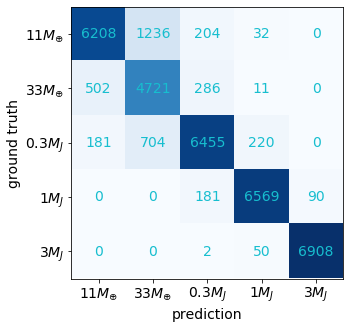

In [22]:
confusion_mat = np.zeros((5,5), dtype='int')
for i in range(5):
    for j in range(5):
        confusion_mat[i][j] = np.sum((y_test == i) & (y_predict == j))
        
plt.rc("font", size=14)
plt.figure(figsize=(7.5,5))
plt.imshow(confusion_mat, cmap='Blues')
for i in range(5):
    for j in range(5):
        plt.text(j, i, str(confusion_mat[i][j]), color = 'C9',
                 horizontalalignment='center', verticalalignment='center')
plt.xlabel("prediction")
plt.ylabel("ground truth")
plt.xticks(np.arange(5), [r"11$M_{\oplus}$", r"33$M_{\oplus}$", r"0.3$M_J$", r"1$M_J$",  r"3$M_J$"])
plt.yticks(np.arange(5), [r"11$M_{\oplus}$", r"33$M_{\oplus}$", r"0.3$M_J$", r"1$M_J$",  r"3$M_J$"])
#plt.savefig('confusion_matrix_model_nov1_datagen.pdf', bbox_inches='tight', transparent=True)

In [19]:
1440 / 5

288.0

In [ ]:
np.sum(x_test == 0)

In [25]:
34560 / 5

6912.0

In [26]:
7680 / 6912

1.1111111111111112

In [20]:
np.sum(y_test == 0)

7680

In [21]:
np.sum(y_test == 1)

5520

In [22]:
np.sum(y_test == 2)

7560

In [23]:
np.sum(y_test == 3)

6840

In [24]:
np.sum(y_test == 4)

6960

In [10]:
prediction_score = model.predict(x_test[:,:,:,None])
prediction_class = np.argmax(prediction_score, axis=1)

In [14]:
prediction_class.shape

(34560,)

([<matplotlib.axis.YTick at 0x7ff6685cdd10>,
 <a list of 5 Text yticklabel objects>)

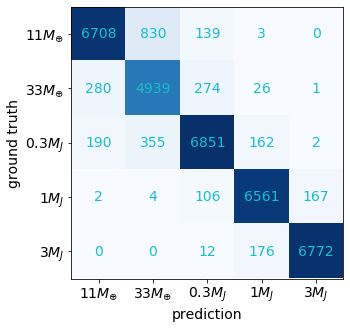

In [15]:
y_predict = prediction_class
#y_test = np.argmax(y_test, axis=1)
confusion_mat = np.zeros((5,5), dtype='int')
for i in range(5):
    for j in range(5):
        confusion_mat[i][j] = np.sum((y_test == i) & (y_predict == j))
        
plt.rc("font", size=14)
plt.figure(figsize=(7.5,5))
plt.imshow(confusion_mat, cmap='Blues')
for i in range(5):
    for j in range(5):
        plt.text(j, i, str(confusion_mat[i][j]), color = 'C9',
                 horizontalalignment='center', verticalalignment='center')
plt.xlabel("prediction")
plt.ylabel("ground truth")
plt.xticks(np.arange(5), [r"11$M_{\oplus}$", r"33$M_{\oplus}$", r"0.3$M_J$", r"1$M_J$",  r"3$M_J$"])
plt.yticks(np.arange(5), [r"11$M_{\oplus}$", r"33$M_{\oplus}$", r"0.3$M_J$", r"1$M_J$",  r"3$M_J$"])
#plt.savefig('confusion_matrix_model_oct24_resnet.pdf', bbox_inches='tight', transparent=True)

([<matplotlib.axis.YTick at 0x7ff6300e0750>,
 <a list of 5 Text yticklabel objects>)

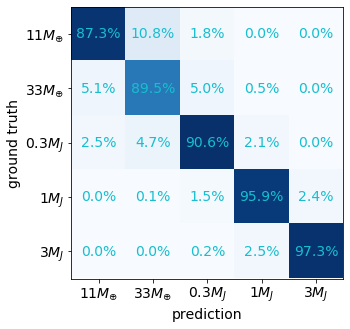

In [30]:
y_predict = prediction_class
#y_test = np.argmax(y_test, axis=1)
confusion_mat = np.zeros((5,5), dtype='int')
for i in range(5):
    for j in range(5):
        confusion_mat[i][j] = np.sum((y_test == i) & (y_predict == j))
        
plt.rc("font", size=14)
plt.figure(figsize=(7.5,5))
plt.imshow(confusion_mat, cmap='Blues')
for i in range(5):
    for j in range(5):
        plt.text(j, i, f"{100*confusion_mat[i][j]/np.sum(confusion_mat[i]):1.1f}%", color = 'C9',
                 horizontalalignment='center', verticalalignment='center')
plt.xlabel("prediction")
plt.ylabel("ground truth")
plt.xticks(np.arange(5), [r"11$M_{\oplus}$", r"33$M_{\oplus}$", r"0.3$M_J$", r"1$M_J$",  r"3$M_J$"])
plt.yticks(np.arange(5), [r"11$M_{\oplus}$", r"33$M_{\oplus}$", r"0.3$M_J$", r"1$M_J$",  r"3$M_J$"])
#plt.savefig('confusion_matrix_model_oct24_resnet.pdf', bbox_inches='tight', transparent=True)

In [18]:
np.sum(confusion_mat, axis=1)

array([7680, 5520, 7560, 6840, 6960])

In [6]:
GW_Lup = np.load("GW_Lup_incl.npy")
model.predict(GW_Lup[None,:,:,None])

array([[1.0629266e-18, 1.8268707e-10, 1.0000000e+00, 4.4645260e-10,
        0.0000000e+00]], dtype=float32)

In [7]:
model = tf.keras.models.load_model("./model_nov1_datagen/model")
GW_Lup = np.load("GW_Lup_incl.npy")
model.predict(GW_Lup[None,:,:,None])

array([[  52.06164  ,   31.077036 ,    2.8923645,  -36.900105 ,
        -422.28754  ]], dtype=float32)

In [8]:
model = tf.keras.models.load_model("./model_nov1_datagen/model")
GW_Lup = np.load("Elias_24.npy")
model.predict(GW_Lup[None,:,:,None])

array([[  81.9121   ,  125.42437  ,   75.77351  ,   -4.9191074,
        -701.1877   ]], dtype=float32)

In [9]:
model = tf.keras.models.load_model("./model_oct24_resnet/model/")
GW_Lup = np.load("Elias_24.npy")
model.predict(GW_Lup[None,:,:,None])

array([[0.0000000e+00, 7.4351603e-36, 9.9999762e-01, 2.4368596e-06,
        0.0000000e+00]], dtype=float32)

In [11]:
model = tf.keras.models.load_model("./model_nov1_datagen/model")
GW_Lup = np.load("Sz_114.npy")
model.predict(GW_Lup[None,:,:,None])

array([[  37.273216,   38.14903 ,    5.919755,  -11.833889, -178.26094 ]],
      dtype=float32)

In [10]:
model = tf.keras.models.load_model("./model_oct24_resnet/model/")
GW_Lup = np.load("Sz_114.npy")
model.predict(GW_Lup[None,:,:,None])

array([[1.5842366e-10, 1.0000000e+00, 1.8977990e-09, 1.3998784e-27,
        0.0000000e+00]], dtype=float32)